In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "../00_setup.py").load_module()

In [2]:
setup.temp_path

'../data/2023_12_15'

# Neural Network Classification Test - Basic

The purpose of this script is to build a standard (not graph) NN and try to get decent performance.  I want to test the data prepared in script 10

Some code based on: https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

*This script takes about 1 hour on my MacBook Air*

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [5]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2024-01-04 08:01:15.555687: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-04 08:01:15.555709: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-04 08:01:15.555717: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-04 08:01:15.555741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-04 08:01:15.555754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.metrics as km

In [7]:
import tensorflow.keras.metrics as km
from keras import initializers

## Input Data

In [8]:
os.chdir('..')

In [9]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_combined_scaled_all.parquet'))

In [10]:
business_data.describe()

,target,menc_NAICS,menc_NAICS_sector,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,...,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,missingindicator_LowDoc,missingindicator_new_business,missingindicator_urban_flag
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,...,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.203011,0.203954,0.202926,0.097958,0.095606,0.079398,0.096843,0.103658,0.098048,0.182085,...,0.499065,0.288307,0.097723,0.504015,0.277935,0.852639,0.050324,0.007342,0.001235,0.198575
std,0.402241,0.095249,0.043782,0.297258,0.294051,0.270359,0.295744,0.304816,0.297380,0.385915,...,0.287491,0.397946,0.296939,0.286781,0.447982,0.354465,0.218613,0.085371,0.035125,0.398928
min,0.000000,0.009628,0.068505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.132721,0.192547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.280280,0.000000,0.000000,0.257093,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.200864,0.218455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.508509,0.000000,0.000000,0.506507,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.264205,0.228565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.750250,0.777778,0.000000,0.751752,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.488372,0.286731,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
business_data.columns

Index(['dset', 'LoanNr_ChkDgt', 'target', 'NAICS', 'NAICS_sector',
       'menc_NAICS', 'menc_NAICS_sector',
       'NS___Accommodation and Food Services', 'NS___Construction',
       'NS___Health Care and Social Assistance', 'NS___Manufacturing',
       'NS___Other Services (except Public Administration)',
       'NS___Professional, Scientific, and Technical Services',
       'NS___Retail Trade', 'NS___Wholesale Trade', 'NS___infrequent_sklearn',
       'NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business',
       'urban_flag', 'franchise_flag', 'missingindicator_LowDoc',
       'missingindicator_new_business', 'missingindicator_urban_flag'],
      dtype='object')

In [12]:
feat = ['new_business','urban_flag', 'franchise_flag','missingindicator_LowDoc',
        'missingindicator_new_business', 'missingindicator_urban_flag', 'NoEmp',
        'CreateJob', 'LowDoc', 'DisbursementGross']


In [13]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + feat].set_index('LoanNr_ChkDgt').sort_index()

In [14]:
X.shape

(688081, 11)

In [15]:
X.columns

Index(['dset', 'new_business', 'urban_flag', 'franchise_flag',
       'missingindicator_LowDoc', 'missingindicator_new_business',
       'missingindicator_urban_flag', 'NoEmp', 'CreateJob', 'LowDoc',
       'DisbursementGross'],
      dtype='object')

In [16]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
X_train.shape

(412848, 10)

In [17]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
X_val.shape

(220187, 10)

In [18]:
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']

In [19]:
y_train.shape

(412848,)

In [20]:
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']

## Function to create model

In [21]:
def create_baseline(base_thresh  = 0.2, n_feat = 10, hidden_size = 4,
                   activation='tanh', n_layers = 2, lr=0.001):
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(10,), activation=activation))
    for i in range(n_layers - 1):
        model.add(Dense(hidden_size, input_shape=(hidden_size,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC'), km.Precision(thresholds=base_thresh), 
                           km.Recall(thresholds=base_thresh)])
    return model

##### Functions to try different hyperparams

In [22]:
def do_model_acts(X_train, y_train, X_val, y_val, 
                  activation_list = ['tanh', 'softmax', 'linear', 'relu', 'leaky_relu'],
                  batch_size = 32, epochs=20, base_thresh  = 0.2, 
                  n_feat = 10, hidden_size = 4, n_layers = 2, lr=0.001):
    
    name_map = ['loss', 'auc', 'precision', 'recall']
    all_hist = pd.DataFrame()
    for i, act in enumerate(activation_list):
        print(f'{i}:{act}')
        try:
            this_model = create_baseline(base_thresh = base_thresh, n_feat = n_feat,
                                     hidden_size = hidden_size, n_layers = n_layers,
                                     activation= act, lr=lr)
            this_history = this_model.fit( X_train, y_train,
                                          validation_data=(X_val, y_val),
                                          batch_size=batch_size,epochs=epochs)
            this_history_df = pd.DataFrame(this_history.history)
        except:
            continue
        start_cols = this_history_df.columns
        try:
            this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                                       if re.search(r'_\d+$', c) else c \
                                       for c in start_cols]
        except:
            this_history_df.columns = start_cols
        this_history_df['run_id'] = i
        this_history_df['activation'] = act
        this_history_df['batch_size'] = batch_size
        this_history_df['epochs'] = epochs
        this_history_df['base_thresh'] = base_thresh
        this_history_df['n_feat'] = n_feat
        this_history_df['hidden_size'] = hidden_size
        this_history_df['n_layers'] = n_layers
        this_history_df['learning_rate'] = lr
        all_hist = pd.concat([all_hist, this_history_df])
        
        
    return all_hist

In [23]:
def do_model_trials_hidden_size(X_train, y_train, X_val, y_val, 
                  activation = 'tanh',
                  batch_size = 32, epochs=15, base_thresh  = 0.2, 
                  n_feat = 10, hidden_size_ary = [4, 8, 16, 32], n_layers = 2,
                             lr=0.001):
    
    name_map = ['loss', 'auc', 'precision', 'recall']
    all_hist = pd.DataFrame()
    for i, x in enumerate(hidden_size_ary):
        print(f'{i}:{x}')
        try:
            this_model = create_baseline(base_thresh = base_thresh, n_feat = n_feat,
                                     hidden_size = x, n_layers = n_layers,
                                     activation= activation, lr=lr)
            this_history = this_model.fit( X_train, y_train,
                                          validation_data=(X_val, y_val),
                                          batch_size=batch_size,epochs=epochs)
            this_history_df = pd.DataFrame(this_history.history)
        except:
            continue
        start_cols = this_history_df.columns
        try:
            this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                                       if re.search(r'_\d+$', c) else c \
                                       for c in start_cols]
        except:
            this_history_df.columns = start_cols
        this_history_df['run_id'] = i
        this_history_df['activation'] = activation
        this_history_df['batch_size'] = batch_size
        this_history_df['epochs'] = epochs
        this_history_df['base_thresh'] = base_thresh
        this_history_df['n_feat'] = n_feat
        this_history_df['hidden_size'] = x
        this_history_df['n_layers'] = n_layers
        this_history_df['learning_rate'] = lr
        all_hist = pd.concat([all_hist, this_history_df])
        
        
    return all_hist

In [41]:
def do_model_trials_batch(X_train, y_train, X_val, y_val, 
                  activation = 'tanh',
                  batch_ary = [16, 32, 64, 128], epochs=15, base_thresh  = 0.2, 
                  n_feat = 10, hidden_size = 16, n_layers = 2,
                             lr=0.0005):
    
    name_map = ['loss', 'auc', 'precision', 'recall']
    all_hist = pd.DataFrame()
    for i, x in enumerate(batch_ary):
        print(f'{i}:{x}')
        try:
            this_model = create_baseline(base_thresh = base_thresh, n_feat = n_feat,
                                     hidden_size = hidden_size, n_layers = n_layers,
                                     activation= activation, lr=lr)
            this_history = this_model.fit( X_train, y_train,
                                          validation_data=(X_val, y_val),
                                          batch_size=x, epochs=epochs)
            this_history_df = pd.DataFrame(this_history.history)
        except:
            continue
        start_cols = this_history_df.columns
        try:
            this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                                       if re.search(r'_\d+$', c) else c \
                                       for c in start_cols]
        except:
            this_history_df.columns = start_cols
        this_history_df['run_id'] = i
        this_history_df['activation'] = activation
        this_history_df['batch_size'] = x
        this_history_df['epochs'] = epochs
        this_history_df['base_thresh'] = base_thresh
        this_history_df['n_feat'] = n_feat
        this_history_df['hidden_size'] = hidden_size
        this_history_df['n_layers'] = n_layers
        this_history_df['learning_rate'] = lr
        all_hist = pd.concat([all_hist, this_history_df])
        
        
    return all_hist

In [25]:
def train_plot(data, field='val_auc', group_field='activation'):
    pivot_data = data[[field, group_field]].pivot(columns=group_field, values=field)
    fig, ax = plt.subplots()
    pivot_data.plot(ax=ax)
    ax.set_ylabel(field)
    ax.set_xlabel('epoch')

## Hyperparameter Search - Activation Function

In [85]:
# Try the activations
all_hist = do_model_acts(X_train, y_train, X_val, y_val)

0:tanh
Epoch 1/20


2024-01-02 22:28:57.074962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4731 - auc_30: 0.3033 - auc_31: 0.6729 - precision_15: 0.2902 - recall_15: 0.7203

2024-01-02 22:32:47.102859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 292s 23ms/step - loss: 0.4731 - auc_30: 0.3033 - auc_31: 0.6729 - precision_15: 0.2902 - recall_15: 0.7203 - val_loss: 0.4689 - val_auc_30: 0.3181 - val_auc_31: 0.6825 - val_precision_15: 0.2915 - val_recall_15: 0.7594
Epoch 2/20
12902/12902 [==============================] - 211s 16ms/step - loss: 0.4680 - auc_30: 0.3195 - auc_31: 0.6829 - precision_15: 0.2943 - recall_15: 0.7376 - val_loss: 0.4677 - val_auc_30: 0.3200 - val_auc_31: 0.6838 - val_precision_15: 0.3012 - val_recall_15: 0.6879
Epoch 3/20
12902/12902 [==============================] - 210s 16ms/step - loss: 0.4663 - auc_30: 0.3223 - auc_31: 0.6855 - precision_15: 0.2936 - recall_15: 0.7533 - val_loss: 0.4647 - val_auc_30: 0.3244 - val_auc_31: 0.6880 - val_precision_15: 0.2939 - val_recall_15: 0.7628
Epoch 4/20
12902/12902 [==============================] - 412s 32ms/step - loss: 0.4642 - auc_30: 0.3282 - auc_31: 0.6903 - precision_15: 0.2937 - recall_15: 0.7691 - val_loss: 0.4

2024-01-03 00:02:26.642788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4795 - auc_32: 0.2840 - auc_33: 0.6594 - precision_16: 0.2759 - recall_16: 0.7708

2024-01-03 00:05:04.285306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 210s 16ms/step - loss: 0.4795 - auc_32: 0.2840 - auc_33: 0.6594 - precision_16: 0.2759 - recall_16: 0.7708 - val_loss: 0.4669 - val_auc_32: 0.3175 - val_auc_33: 0.6840 - val_precision_16: 0.2964 - val_recall_16: 0.7429
Epoch 2/20
12902/12902 [==============================] - 209s 16ms/step - loss: 0.4661 - auc_32: 0.3200 - auc_33: 0.6862 - precision_16: 0.2949 - recall_16: 0.7565 - val_loss: 0.4652 - val_auc_32: 0.3217 - val_auc_33: 0.6878 - val_precision_16: 0.2951 - val_recall_16: 0.7619
Epoch 3/20
12902/12902 [==============================] - 2817s 218ms/step - loss: 0.4652 - auc_32: 0.3223 - auc_33: 0.6881 - precision_16: 0.2942 - recall_16: 0.7681 - val_loss: 0.4648 - val_auc_32: 0.3229 - val_auc_33: 0.6890 - val_precision_16: 0.2964 - val_recall_16: 0.7528
Epoch 4/20
12902/12902 [==============================] - 2006s 155ms/step - loss: 0.4648 - auc_32: 0.3238 - auc_33: 0.6891 - precision_16: 0.2936 - recall_16: 0.7723 - val_loss:

2024-01-03 04:55:23.021401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4724 - auc_34: 0.3021 - auc_35: 0.6730 - precision_17: 0.2911 - recall_17: 0.7361

2024-01-03 04:57:51.282837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 200s 15ms/step - loss: 0.4724 - auc_34: 0.3021 - auc_35: 0.6730 - precision_17: 0.2911 - recall_17: 0.7361 - val_loss: 0.4706 - val_auc_34: 0.3120 - val_auc_35: 0.6776 - val_precision_17: 0.3018 - val_recall_17: 0.6817
Epoch 2/20
12902/12902 [==============================] - 198s 15ms/step - loss: 0.4706 - auc_34: 0.3124 - auc_35: 0.6769 - precision_17: 0.2939 - recall_17: 0.7315 - val_loss: 0.4703 - val_auc_34: 0.3123 - val_auc_35: 0.6774 - val_precision_17: 0.2961 - val_recall_17: 0.7312
Epoch 3/20
12902/12902 [==============================] - 198s 15ms/step - loss: 0.4705 - auc_34: 0.3126 - auc_35: 0.6770 - precision_17: 0.2939 - recall_17: 0.7318 - val_loss: 0.4703 - val_auc_34: 0.3134 - val_auc_35: 0.6773 - val_precision_17: 0.2947 - val_recall_17: 0.7371
Epoch 4/20
12902/12902 [==============================] - 199s 15ms/step - loss: 0.4705 - auc_34: 0.3128 - auc_35: 0.6772 - precision_17: 0.2940 - recall_17: 0.7315 - val_loss: 0.4

2024-01-03 07:30:58.361488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4737 - auc_36: 0.3005 - auc_37: 0.6708 - precision_18: 0.2906 - recall_18: 0.7195

2024-01-03 07:53:47.369126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 1421s 110ms/step - loss: 0.4737 - auc_36: 0.3005 - auc_37: 0.6708 - precision_18: 0.2906 - recall_18: 0.7195 - val_loss: 0.4716 - val_auc_36: 0.3144 - val_auc_37: 0.6770 - val_precision_18: 0.2913 - val_recall_18: 0.7546
Epoch 2/20
12902/12902 [==============================] - 1098s 85ms/step - loss: 0.4721 - auc_36: 0.3117 - auc_37: 0.6758 - precision_18: 0.2983 - recall_18: 0.7008 - val_loss: 0.4722 - val_auc_36: 0.3109 - val_auc_37: 0.6749 - val_precision_18: 0.2994 - val_recall_18: 0.6883
Epoch 3/20
12902/12902 [==============================] - 1490s 116ms/step - loss: 0.4729 - auc_36: 0.3079 - auc_37: 0.6735 - precision_18: 0.2960 - recall_18: 0.7001 - val_loss: 0.4736 - val_auc_36: 0.3009 - val_auc_37: 0.6713 - val_precision_18: 0.2946 - val_recall_18: 0.7001
Epoch 4/20
12902/12902 [==============================] - 201s 16ms/step - loss: 0.4739 - auc_36: 0.3046 - auc_37: 0.6710 - precision_18: 0.2937 - recall_18: 0.6927 - val_loss

2024-01-03 10:04:41.848210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4700 - auc_38: 0.3132 - auc_39: 0.6777 - precision_19: 0.2918 - recall_19: 0.7386

2024-01-03 10:07:14.663006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 204s 16ms/step - loss: 0.4700 - auc_38: 0.3132 - auc_39: 0.6777 - precision_19: 0.2918 - recall_19: 0.7386 - val_loss: 0.4678 - val_auc_38: 0.3177 - val_auc_39: 0.6816 - val_precision_19: 0.2952 - val_recall_19: 0.7411
Epoch 2/20
12902/12902 [==============================] - 204s 16ms/step - loss: 0.4674 - auc_38: 0.3202 - auc_39: 0.6835 - precision_19: 0.2940 - recall_19: 0.7497 - val_loss: 0.4666 - val_auc_38: 0.3209 - val_auc_39: 0.6849 - val_precision_19: 0.2918 - val_recall_19: 0.7706
Epoch 3/20
12902/12902 [==============================] - 206s 16ms/step - loss: 0.4664 - auc_38: 0.3228 - auc_39: 0.6859 - precision_19: 0.2932 - recall_19: 0.7591 - val_loss: 0.4662 - val_auc_38: 0.3228 - val_auc_39: 0.6864 - val_precision_19: 0.2872 - val_recall_19: 0.7919
Epoch 4/20
12902/12902 [==============================] - 203s 16ms/step - loss: 0.4660 - auc_38: 0.3239 - auc_39: 0.6868 - precision_19: 0.2927 - recall_19: 0.7628 - val_loss: 0.4

In [97]:
all_hist.head(2)

,loss,auc,auc_roc,precision,recall,val_loss,val_auc,val_auc_roc,val_precision,val_recall,run_id,activation,batch_size,epochs,base_thresh,n_feat,hidden_size,n_layers
0,0.473139,0.303330,0.672929,0.290246,0.720342,0.468946,0.318116,0.682475,0.291546,0.759351,0,tanh,32,20,0.2,10,4,2
1,0.468032,0.319533,0.682877,0.294339,0.737618,0.467671,0.319999,0.683762,0.301241,0.687875,0,tanh,32,20,0.2,10,4,2


In [95]:
cur_col = list(all_hist.columns)
all_hist.columns = [cur_col[0]] + [f'{cur_col[i]}_roc' if cur_col[i] == cur_col[i-1] else cur_col[i] for i in range(1, len(cur_col))]

In [ ]:
all_hist.to_parquet(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_activations.parquet'))
all_hist.to_csv(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_activations.csv'))

In [100]:
all_hist.groupby('run_id').tail(1).sort_values('val_auc', ascending=False)

,loss,auc,auc_roc,precision,recall,val_loss,val_auc,val_auc_roc,val_precision,val_recall,run_id,activation,batch_size,epochs,base_thresh,n_feat,hidden_size,n_layers
19,0.461695,0.338383,0.698220,0.294155,0.774725,0.460822,0.341484,0.700218,0.293340,0.783087,0,tanh,32,20,0.2,10,4,2
19,0.462645,0.333395,0.695832,0.296382,0.757365,0.461811,0.334324,0.697643,0.297869,0.756667,4,leaky_relu,32,20,0.2,10,4,2
19,0.463372,0.329189,0.692341,0.292815,0.779259,0.462879,0.329756,0.692461,0.293893,0.779553,1,softmax,32,20,0.2,10,4,2
19,0.470344,0.313166,0.677564,0.294248,0.731438,0.470848,0.312381,0.676906,0.300135,0.697360,2,linear,32,20,0.2,10,4,2
19,0.476321,0.304837,0.667849,0.293814,0.673404,0.474033,0.310227,0.674363,0.303844,0.631119,3,relu,32,20,0.2,10,4,2


Tanh for the win!  After 20 epochs, relu is the worst, followed by linear.  Don't use those!

### Plot training curves for these

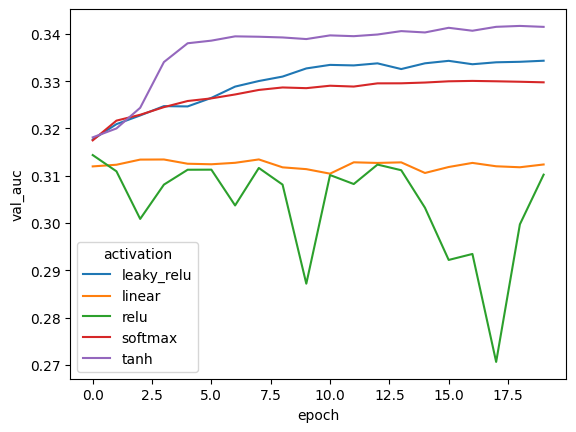

In [127]:
train_plot(all_hist)

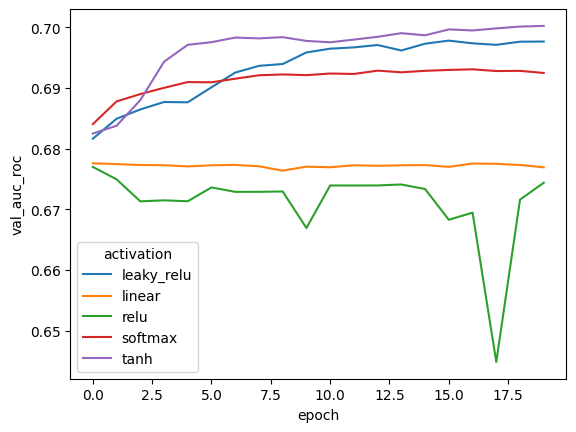

In [128]:
train_plot(all_hist, 'val_auc_roc')

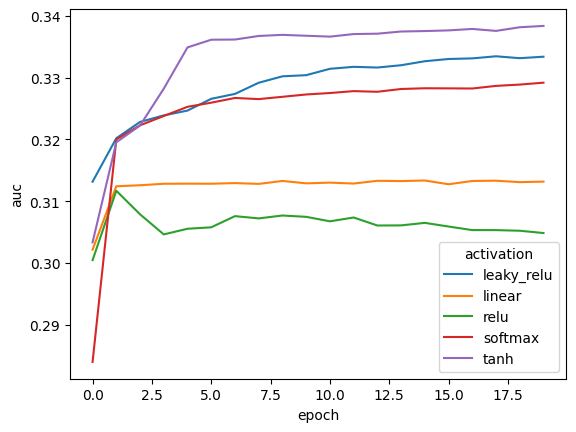

In [129]:
train_plot(all_hist, 'auc')

## Hidden Layer Size

In [118]:
# Try the activations
all_hist_hz = do_model_trials_hidden_size(X_train, y_train, X_val, y_val)

0:4
Epoch 1/15


2024-01-03 21:49:17.052603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4724 - auc_48: 0.3057 - auc_49: 0.6739 - precision_24: 0.2911 - recall_24: 0.7293

2024-01-03 21:53:14.108562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 319s 25ms/step - loss: 0.4724 - auc_48: 0.3057 - auc_49: 0.6739 - precision_24: 0.2911 - recall_24: 0.7293 - val_loss: 0.4713 - val_auc_48: 0.3179 - val_auc_49: 0.6790 - val_precision_24: 0.2782 - val_recall_24: 0.8097
Epoch 2/15
12902/12902 [==============================] - 317s 25ms/step - loss: 0.4688 - auc_48: 0.3162 - auc_49: 0.6806 - precision_24: 0.2918 - recall_24: 0.7498 - val_loss: 0.4676 - val_auc_48: 0.3175 - val_auc_49: 0.6829 - val_precision_24: 0.2917 - val_recall_24: 0.7599
Epoch 3/15
12902/12902 [==============================] - 352s 27ms/step - loss: 0.4670 - auc_48: 0.3185 - auc_49: 0.6842 - precision_24: 0.2915 - recall_24: 0.7682 - val_loss: 0.4670 - val_auc_48: 0.3238 - val_auc_49: 0.6883 - val_precision_24: 0.2819 - val_recall_24: 0.8245
Epoch 4/15
12902/12902 [==============================] - 313s 24ms/step - loss: 0.4649 - auc_48: 0.3250 - auc_49: 0.6888 - precision_24: 0.2914 - recall_24: 0.7809 - val_loss: 0.4

2024-01-04 00:24:57.681739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4719 - auc_50: 0.3019 - auc_51: 0.6751 - precision_25: 0.2923 - recall_25: 0.7211

2024-01-04 00:27:29.838912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 204s 16ms/step - loss: 0.4719 - auc_50: 0.3019 - auc_51: 0.6751 - precision_25: 0.2923 - recall_25: 0.7211 - val_loss: 0.4669 - val_auc_50: 0.3195 - val_auc_51: 0.6857 - val_precision_25: 0.2910 - val_recall_25: 0.7654
Epoch 2/15
12902/12902 [==============================] - 203s 16ms/step - loss: 0.4653 - auc_50: 0.3234 - auc_51: 0.6894 - precision_25: 0.2973 - recall_25: 0.7305 - val_loss: 0.4631 - val_auc_50: 0.3308 - val_auc_51: 0.6957 - val_precision_25: 0.2961 - val_recall_25: 0.7543
Epoch 3/15
12902/12902 [==============================] - 203s 16ms/step - loss: 0.4633 - auc_50: 0.3303 - auc_51: 0.6947 - precision_25: 0.2967 - recall_25: 0.7466 - val_loss: 0.4625 - val_auc_50: 0.3366 - val_auc_51: 0.6985 - val_precision_25: 0.2911 - val_recall_25: 0.7877
Epoch 4/15
12902/12902 [==============================] - 204s 16ms/step - loss: 0.4626 - auc_50: 0.3337 - auc_51: 0.6966 - precision_25: 0.2960 - recall_25: 0.7560 - val_loss: 0.4

2024-01-04 01:45:49.774400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4699 - auc_52: 0.3096 - auc_53: 0.6786 - precision_26: 0.2927 - recall_26: 0.7310

2024-01-04 02:03:48.809693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 1131s 88ms/step - loss: 0.4699 - auc_52: 0.3096 - auc_53: 0.6786 - precision_26: 0.2927 - recall_26: 0.7310 - val_loss: 0.4653 - val_auc_52: 0.3260 - val_auc_53: 0.6896 - val_precision_26: 0.2902 - val_recall_26: 0.7742
Epoch 2/15
12902/12902 [==============================] - 202s 16ms/step - loss: 0.4644 - auc_52: 0.3277 - auc_53: 0.6916 - precision_26: 0.2968 - recall_26: 0.7392 - val_loss: 0.4625 - val_auc_52: 0.3359 - val_auc_53: 0.6965 - val_precision_26: 0.2926 - val_recall_26: 0.7758
Epoch 3/15
12902/12902 [==============================] - 202s 16ms/step - loss: 0.4632 - auc_52: 0.3335 - auc_53: 0.6946 - precision_26: 0.2972 - recall_26: 0.7456 - val_loss: 0.4629 - val_auc_52: 0.3332 - val_auc_53: 0.6962 - val_precision_26: 0.2933 - val_recall_26: 0.7765
Epoch 4/15
12902/12902 [==============================] - 203s 16ms/step - loss: 0.4629 - auc_52: 0.3346 - auc_53: 0.6953 - precision_26: 0.2968 - recall_26: 0.7509 - val_loss: 0.

2024-01-04 02:52:06.805075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4693 - auc_54: 0.3151 - auc_55: 0.6801 - precision_27: 0.2926 - recall_27: 0.7296

2024-01-04 02:54:40.683884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 205s 16ms/step - loss: 0.4693 - auc_54: 0.3151 - auc_55: 0.6801 - precision_27: 0.2926 - recall_27: 0.7296 - val_loss: 0.4672 - val_auc_54: 0.3235 - val_auc_55: 0.6868 - val_precision_27: 0.3024 - val_recall_27: 0.6866
Epoch 2/15
12902/12902 [==============================] - 204s 16ms/step - loss: 0.4641 - auc_54: 0.3292 - auc_55: 0.6920 - precision_27: 0.2933 - recall_27: 0.7639 - val_loss: 0.4618 - val_auc_54: 0.3390 - val_auc_55: 0.6997 - val_precision_27: 0.2974 - val_recall_27: 0.7613
Epoch 3/15
12902/12902 [==============================] - 204s 16ms/step - loss: 0.4625 - auc_54: 0.3346 - auc_55: 0.6967 - precision_27: 0.2935 - recall_27: 0.7715 - val_loss: 0.4612 - val_auc_54: 0.3391 - val_auc_55: 0.7005 - val_precision_27: 0.2968 - val_recall_27: 0.7649
Epoch 4/15
12902/12902 [==============================] - 2104s 163ms/step - loss: 0.4619 - auc_54: 0.3372 - auc_55: 0.6982 - precision_27: 0.2957 - recall_27: 0.7693 - val_loss: 0

In [119]:
cur_col = list(all_hist_hz.columns)
all_hist_hz.columns = [cur_col[0]] + [f'{cur_col[i]}_roc' if cur_col[i] == cur_col[i-1] else cur_col[i] for i in range(1, len(cur_col))]

In [125]:
all_hist_hz.to_parquet(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_hidden_size.parquet'))
all_hist_hz.to_csv(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_hidden_size.csv'))

In [121]:
all_hist_hz.groupby('run_id').tail(1).sort_values('val_auc', ascending=False)

,loss,auc,auc_roc,precision,recall,val_loss,val_auc,val_auc_roc,val_precision,val_recall,run_id,activation,batch_size,epochs,base_thresh,n_feat,hidden_size,n_layers
14,0.460655,0.341163,0.700905,0.296127,0.770501,0.459832,0.344639,0.703396,0.291686,0.799978,3,tanh,32,15,0.2,10,32,2
14,0.461124,0.340085,0.699763,0.294356,0.774939,0.460540,0.344006,0.702528,0.295946,0.774676,1,tanh,32,15,0.2,10,8,2
14,0.461124,0.340197,0.699868,0.296856,0.760240,0.462024,0.340803,0.700279,0.287414,0.807517,2,tanh,32,15,0.2,10,16,2
14,0.462187,0.337117,0.697317,0.292240,0.784437,0.461318,0.340443,0.699444,0.290938,0.793356,0,tanh,32,15,0.2,10,4,2


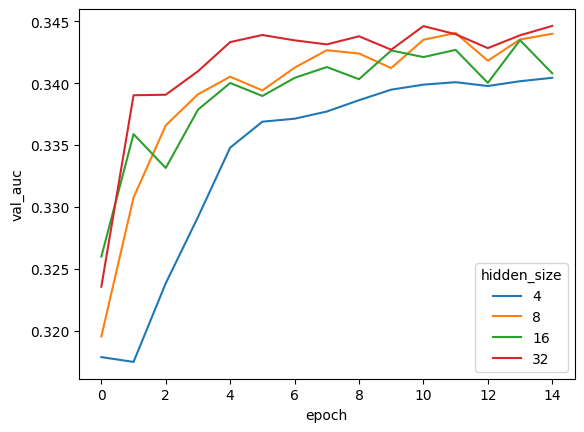

In [136]:
train_plot(all_hist_hz, 'val_auc', 'hidden_size')

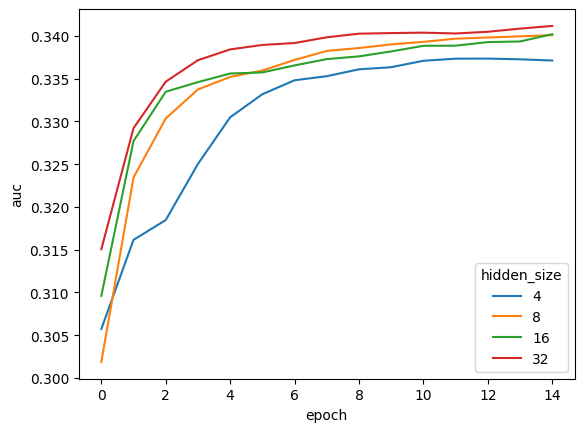

In [135]:
train_plot(all_hist_hz, 'auc', 'hidden_size')

## Vary sizes again, for a shorter learn rate

In [26]:
# Try the activations
all_hist_hz_lr = do_model_trials_hidden_size(X_train, y_train, X_val, y_val, lr=0.0001,
                                            hidden_size_ary=[8,16,32,64])

0:8
Epoch 1/15


2024-01-04 08:01:39.483109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4878 - auc: 0.2691 - auc_1: 0.6443 - precision: 0.2723 - recall: 0.7404

2024-01-04 08:04:15.678377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 208s 16ms/step - loss: 0.4878 - auc: 0.2691 - auc_1: 0.6443 - precision: 0.2723 - recall: 0.7404 - val_loss: 0.4710 - val_auc: 0.3105 - val_auc_1: 0.6762 - val_precision: 0.2926 - val_recall: 0.7249
Epoch 2/15
12902/12902 [==============================] - 208s 16ms/step - loss: 0.4700 - auc: 0.3141 - auc_1: 0.6789 - precision: 0.2924 - recall: 0.7387 - val_loss: 0.4697 - val_auc: 0.3135 - val_auc_1: 0.6792 - val_precision: 0.2976 - val_recall: 0.7143
Epoch 3/15
12902/12902 [==============================] - 207s 16ms/step - loss: 0.4693 - auc: 0.3154 - auc_1: 0.6802 - precision: 0.2940 - recall: 0.7360 - val_loss: 0.4693 - val_auc: 0.3140 - val_auc_1: 0.6804 - val_precision: 0.2973 - val_recall: 0.7204
Epoch 4/15
12902/12902 [==============================] - 1109s 86ms/step - loss: 0.4690 - auc: 0.3159 - auc_1: 0.6810 - precision: 0.2944 - recall: 0.7344 - val_loss: 0.4689 - val_auc: 0.3154 - val_auc_1: 0.6809 - val_precision: 0.2956 - v

2024-01-04 10:07:42.218762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4770 - auc_2: 0.2894 - auc_3: 0.6631 - precision_1: 0.2861 - recall_1: 0.7255

2024-01-04 10:10:17.238640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 209s 16ms/step - loss: 0.4770 - auc_2: 0.2894 - auc_3: 0.6631 - precision_1: 0.2861 - recall_1: 0.7255 - val_loss: 0.4707 - val_auc_2: 0.3108 - val_auc_3: 0.6773 - val_precision_1: 0.2975 - val_recall_1: 0.7210
Epoch 2/15
12902/12902 [==============================] - 211s 16ms/step - loss: 0.4703 - auc_2: 0.3139 - auc_3: 0.6783 - precision_1: 0.2967 - recall_1: 0.7247 - val_loss: 0.4701 - val_auc_2: 0.3142 - val_auc_3: 0.6783 - val_precision_1: 0.2986 - val_recall_1: 0.7154
Epoch 3/15
12902/12902 [==============================] - 211s 16ms/step - loss: 0.4697 - auc_2: 0.3160 - auc_3: 0.6795 - precision_1: 0.2970 - recall_1: 0.7248 - val_loss: 0.4694 - val_auc_2: 0.3151 - val_auc_3: 0.6797 - val_precision_1: 0.2960 - val_recall_1: 0.7357
Epoch 4/15
12902/12902 [==============================] - 211s 16ms/step - loss: 0.4691 - auc_2: 0.3174 - auc_3: 0.6808 - precision_1: 0.2969 - recall_1: 0.7269 - val_loss: 0.4689 - val_auc_2: 0.3160 - va

2024-01-04 11:13:52.430820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4740 - auc_4: 0.2960 - auc_5: 0.6696 - precision_2: 0.2900 - recall_2: 0.7297

2024-01-04 11:16:23.153577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 204s 16ms/step - loss: 0.4740 - auc_4: 0.2960 - auc_5: 0.6696 - precision_2: 0.2900 - recall_2: 0.7297 - val_loss: 0.4701 - val_auc_4: 0.3110 - val_auc_5: 0.6779 - val_precision_2: 0.2964 - val_recall_2: 0.7270
Epoch 2/15
12902/12902 [==============================] - 202s 16ms/step - loss: 0.4698 - auc_4: 0.3140 - auc_5: 0.6789 - precision_2: 0.2957 - recall_2: 0.7258 - val_loss: 0.4697 - val_auc_4: 0.3156 - val_auc_5: 0.6799 - val_precision_2: 0.2906 - val_recall_2: 0.7516
Epoch 3/15
12902/12902 [==============================] - 202s 16ms/step - loss: 0.4691 - auc_4: 0.3169 - auc_5: 0.6809 - precision_2: 0.2963 - recall_2: 0.7244 - val_loss: 0.4686 - val_auc_4: 0.3178 - val_auc_5: 0.6819 - val_precision_2: 0.2948 - val_recall_2: 0.7389
Epoch 4/15
12902/12902 [==============================] - 202s 16ms/step - loss: 0.4683 - auc_4: 0.3194 - auc_5: 0.6828 - precision_2: 0.2961 - recall_2: 0.7265 - val_loss: 0.4678 - val_auc_4: 0.3189 - va

2024-01-04 13:19:39.141019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4725 - auc_6: 0.3017 - auc_7: 0.6731 - precision_3: 0.2926 - recall_3: 0.7276

2024-01-04 13:22:08.700520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 201s 16ms/step - loss: 0.4725 - auc_6: 0.3017 - auc_7: 0.6731 - precision_3: 0.2926 - recall_3: 0.7276 - val_loss: 0.4703 - val_auc_6: 0.3118 - val_auc_7: 0.6775 - val_precision_3: 0.2990 - val_recall_3: 0.7129
Epoch 2/15
12902/12902 [==============================] - 241s 19ms/step - loss: 0.4699 - auc_6: 0.3139 - auc_7: 0.6787 - precision_3: 0.2949 - recall_3: 0.7283 - val_loss: 0.4694 - val_auc_6: 0.3124 - val_auc_7: 0.6795 - val_precision_3: 0.2938 - val_recall_3: 0.7436
Epoch 3/15
12902/12902 [==============================] - 256s 20ms/step - loss: 0.4689 - auc_6: 0.3168 - auc_7: 0.6812 - precision_3: 0.2956 - recall_3: 0.7339 - val_loss: 0.4681 - val_auc_6: 0.3181 - val_auc_7: 0.6830 - val_precision_3: 0.3000 - val_recall_3: 0.6994
Epoch 4/15
12902/12902 [==============================] - 297s 23ms/step - loss: 0.4674 - auc_6: 0.3205 - auc_7: 0.6838 - precision_3: 0.2949 - recall_3: 0.7425 - val_loss: 0.4665 - val_auc_6: 0.3209 - va

In [27]:
cur_col = list(all_hist_hz_lr.columns)
all_hist_hz_lr.columns = [cur_col[0]] + \
    [f'{cur_col[i]}_roc' if cur_col[i] == cur_col[i-1] else cur_col[i] \
     for i in range(1, len(cur_col))]

In [28]:
all_hist_hz_lr.to_parquet(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_hidden_size_lr.parquet'))
all_hist_hz_lr.to_csv(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_hidden_size_lr.csv'))

In [29]:
all_hist_hz_lr.groupby('run_id').tail(1).sort_values('val_auc', ascending=False)

,loss,auc,auc_roc,precision,recall,val_loss,val_auc,val_auc_roc,val_precision,val_recall,run_id,activation,batch_size,epochs,base_thresh,n_feat,hidden_size,n_layers,learning_rate
14,0.461406,0.339596,0.699120,0.295539,0.769893,0.460606,0.342049,0.701409,0.296279,0.768456,3,tanh,32,15,0.2,10,64,2,0.0001
14,0.462803,0.333184,0.695533,0.297256,0.749430,0.462098,0.334718,0.697137,0.296154,0.760626,2,tanh,32,15,0.2,10,32,2,0.0001
14,0.464096,0.329832,0.692827,0.294749,0.759286,0.463623,0.331000,0.694582,0.289921,0.790336,1,tanh,32,15,0.2,10,16,2,0.0001
14,0.465731,0.322757,0.686460,0.294409,0.759381,0.465468,0.322143,0.686929,0.296076,0.750112,0,tanh,32,15,0.2,10,8,2,0.0001


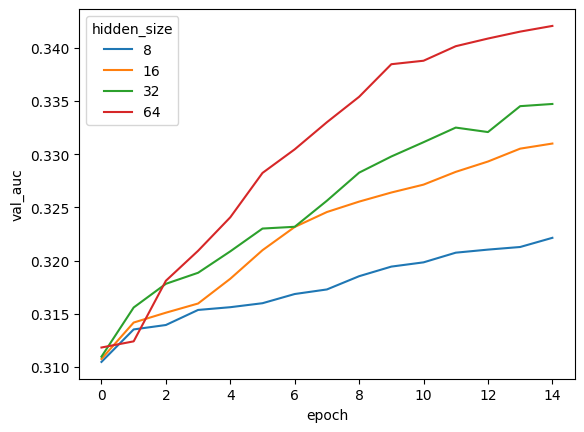

In [32]:
train_plot(all_hist_hz_lr, 'val_auc', 'hidden_size')

In [33]:
# Another learning rate
all_hist_hz_lr3 = do_model_trials_hidden_size(X_train, y_train, X_val, y_val, lr=0.0005,
                                            hidden_size_ary=[8,16,32,64])

0:8
Epoch 1/15


2024-01-04 17:16:11.962659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4732 - auc_8: 0.3048 - auc_9: 0.6729 - precision_4: 0.2920 - recall_4: 0.7265

2024-01-04 17:18:51.020054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 211s 16ms/step - loss: 0.4732 - auc_8: 0.3048 - auc_9: 0.6729 - precision_4: 0.2920 - recall_4: 0.7265 - val_loss: 0.4682 - val_auc_8: 0.3209 - val_auc_9: 0.6817 - val_precision_4: 0.2909 - val_recall_4: 0.7566
Epoch 2/15
12902/12902 [==============================] - 209s 16ms/step - loss: 0.4669 - auc_8: 0.3232 - auc_9: 0.6846 - precision_4: 0.2924 - recall_4: 0.7488 - val_loss: 0.4655 - val_auc_8: 0.3270 - val_auc_9: 0.6892 - val_precision_4: 0.2953 - val_recall_4: 0.7493
Epoch 3/15
12902/12902 [==============================] - 207s 16ms/step - loss: 0.4650 - auc_8: 0.3283 - auc_9: 0.6902 - precision_4: 0.2929 - recall_4: 0.7637 - val_loss: 0.4637 - val_auc_8: 0.3325 - val_auc_9: 0.6934 - val_precision_4: 0.2928 - val_recall_4: 0.7756
Epoch 4/15
12902/12902 [==============================] - 1106s 86ms/step - loss: 0.4639 - auc_8: 0.3314 - auc_9: 0.6934 - precision_4: 0.2943 - recall_4: 0.7670 - val_loss: 0.4631 - val_auc_8: 0.3356 - v

2024-01-04 18:36:49.096750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4708 - auc_10: 0.3085 - auc_11: 0.6778 - precision_5: 0.2927 - recall_5: 0.7250

2024-01-04 18:39:18.944065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 201s 16ms/step - loss: 0.4708 - auc_10: 0.3085 - auc_11: 0.6778 - precision_5: 0.2927 - recall_5: 0.7250 - val_loss: 0.4687 - val_auc_10: 0.3218 - val_auc_11: 0.6860 - val_precision_5: 0.2912 - val_recall_5: 0.7645
Epoch 2/15
12902/12902 [==============================] - 200s 15ms/step - loss: 0.4672 - auc_10: 0.3214 - auc_11: 0.6852 - precision_5: 0.2954 - recall_5: 0.7347 - val_loss: 0.4657 - val_auc_10: 0.3230 - val_auc_11: 0.6874 - val_precision_5: 0.2986 - val_recall_5: 0.7240
Epoch 3/15
12902/12902 [==============================] - 200s 16ms/step - loss: 0.4654 - auc_10: 0.3255 - auc_11: 0.6888 - precision_5: 0.2956 - recall_5: 0.7411 - val_loss: 0.4639 - val_auc_10: 0.3300 - val_auc_11: 0.6938 - val_precision_5: 0.3007 - val_recall_5: 0.7259
Epoch 4/15
12902/12902 [==============================] - 200s 16ms/step - loss: 0.4639 - auc_10: 0.3292 - auc_11: 0.6932 - precision_5: 0.2965 - recall_5: 0.7399 - val_loss: 0.4626 - val_auc_

2024-01-04 19:45:35.215426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4705 - auc_12: 0.3096 - auc_13: 0.6772 - precision_6: 0.2927 - recall_6: 0.7287

2024-01-04 19:48:05.873405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 202s 16ms/step - loss: 0.4705 - auc_12: 0.3096 - auc_13: 0.6772 - precision_6: 0.2927 - recall_6: 0.7287 - val_loss: 0.4684 - val_auc_12: 0.3226 - val_auc_13: 0.6862 - val_precision_6: 0.2856 - val_recall_6: 0.7977
Epoch 2/15
12902/12902 [==============================] - 202s 16ms/step - loss: 0.4655 - auc_12: 0.3253 - auc_13: 0.6882 - precision_6: 0.2957 - recall_6: 0.7400 - val_loss: 0.4640 - val_auc_12: 0.3292 - val_auc_13: 0.6929 - val_precision_6: 0.2961 - val_recall_6: 0.7460
Epoch 3/15
12902/12902 [==============================] - 202s 16ms/step - loss: 0.4636 - auc_12: 0.3302 - auc_13: 0.6935 - precision_6: 0.2951 - recall_6: 0.7540 - val_loss: 0.4627 - val_auc_12: 0.3342 - val_auc_13: 0.6973 - val_precision_6: 0.2926 - val_recall_6: 0.7782
Epoch 4/15
12902/12902 [==============================] - 202s 16ms/step - loss: 0.4631 - auc_12: 0.3325 - auc_13: 0.6952 - precision_6: 0.2946 - recall_6: 0.7637 - val_loss: 0.4624 - val_auc_

2024-01-04 20:36:06.593981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - ETA: 0s - loss: 0.4704 - auc_14: 0.3106 - auc_15: 0.6773 - precision_7: 0.2922 - recall_7: 0.7279

2024-01-04 20:49:11.065504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12902/12902 [==============================] - 838s 65ms/step - loss: 0.4704 - auc_14: 0.3106 - auc_15: 0.6773 - precision_7: 0.2922 - recall_7: 0.7279 - val_loss: 0.4674 - val_auc_14: 0.3194 - val_auc_15: 0.6832 - val_precision_7: 0.2990 - val_recall_7: 0.6862
Epoch 2/15
12902/12902 [==============================] - 219s 17ms/step - loss: 0.4653 - auc_14: 0.3252 - auc_15: 0.6895 - precision_7: 0.2964 - recall_7: 0.7405 - val_loss: 0.4634 - val_auc_14: 0.3336 - val_auc_15: 0.6959 - val_precision_7: 0.3044 - val_recall_7: 0.6981
Epoch 3/15
12902/12902 [==============================] - 209s 16ms/step - loss: 0.4636 - auc_14: 0.3313 - auc_15: 0.6941 - precision_7: 0.2973 - recall_7: 0.7432 - val_loss: 0.4618 - val_auc_14: 0.3392 - val_auc_15: 0.6990 - val_precision_7: 0.2975 - val_recall_7: 0.7548
Epoch 4/15
12902/12902 [==============================] - 213s 17ms/step - loss: 0.4626 - auc_14: 0.3362 - auc_15: 0.6965 - precision_7: 0.2969 - recall_7: 0.7535 - val_loss: 0.4623 - val_auc_

In [34]:
cur_col = list(all_hist_hz_lr3.columns)
all_hist_hz_lr3.columns = [cur_col[0]] + \
    [f'{cur_col[i]}_roc' if cur_col[i] == cur_col[i-1] else cur_col[i] \
     for i in range(1, len(cur_col))]

In [35]:
all_hist_hz_lr3.to_parquet(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_hidden_size_lr3.parquet'))
all_hist_hz_lr3.to_csv(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_hidden_size_lr3.csv'))

In [36]:
all_hist_hz_lr3.groupby('run_id').tail(1).sort_values('val_auc', ascending=False)

,loss,auc,auc_roc,precision,recall,val_loss,val_auc,val_auc_roc,val_precision,val_recall,run_id,activation,batch_size,epochs,base_thresh,n_feat,hidden_size,n_layers,learning_rate
14,0.460834,0.340581,0.700600,0.296519,0.764261,0.459980,0.343910,0.703160,0.301701,0.744452,3,tanh,32,15,0.2,10,64,2,0.0005
14,0.461746,0.336897,0.698248,0.296215,0.764106,0.461169,0.342303,0.701412,0.291234,0.793445,0,tanh,32,15,0.2,10,8,2,0.0005
14,0.461502,0.338949,0.699063,0.296952,0.757042,0.460763,0.341935,0.701573,0.295042,0.775817,1,tanh,32,15,0.2,10,16,2,0.0005
14,0.461248,0.339656,0.699540,0.295587,0.768914,0.460918,0.340594,0.701608,0.297095,0.764944,2,tanh,32,15,0.2,10,32,2,0.0005


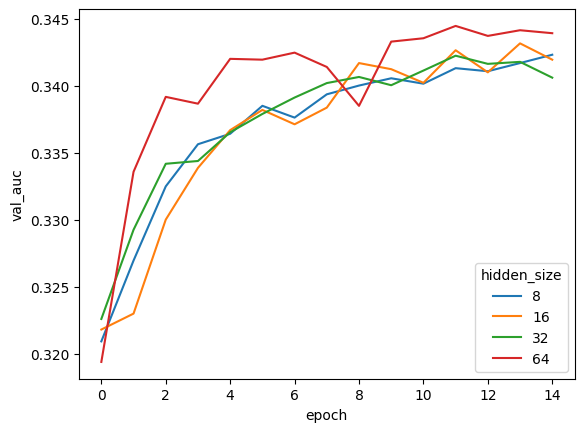

In [37]:
train_plot(all_hist_hz_lr3, 'val_auc', 'hidden_size')

## Batch Size

In [ ]:
# Try the activations
all_hist_batch = do_model_trials_batch(X_train, y_train, X_val, y_val)

0:16
Epoch 1/15


2024-01-04 22:10:24.062020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25263/25803 [============================>.] - ETA: 5s - loss: 0.4706 - auc_16: 0.3108 - auc_17: 0.6782 - precision_8: 0.2939 - recall_8: 0.7219

In [ ]:
cur_col = list(all_hist_batch.columns)
all_hist_batch.columns = [cur_col[0]] + \
    [f'{cur_col[i]}_roc' if cur_col[i] == cur_col[i-1] else cur_col[i] \
     for i in range(1, len(cur_col))]

In [ ]:
all_hist_batch.to_parquet(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_batch.parquet'))
all_hist_batch.to_csv(Path(setup.temp_path).joinpath('TMP_10_DATA_keras_test_batch.csv'))

In [38]:
# simple test
test = do_model_trials_batch(X_train.iloc[0:100,:], y_train.iloc[0:100],
                                   X_val.iloc[0:100,:], y_val.iloc[0:100],
                                  epochs=1)

NameError: name 'do_model_trials_batch' is not defined

In [ ]:
TO DO
Dropout (hidden layers) - maybe do 64 plus dropout?  Overfitting doesn't seem an issue yet
Test some parameters with the other scaling
Hold out some NAICS
XGBoost - metrics for "holdout" NAICS (all tests), also redo all NAICS and NN data creation

Regular NN - do both no NAICS and embeddings versions.  Save embeddings for businesses, NAICS!